# Вебинар 6. Двухуровневые модели рекомендаций


In [1]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for implicit: filename=implicit-0.4.8-cp37-cp37m-linux_x86_64.whl size=4606597 sha256=cf6ccba886415b42ef1ef345d9ab09a24e040bc427102de50ae86c6fce398d06
  Stored in directory: /root/.cache/pip/wheels/88/e6/34/25e73cccbaf1a961154bb562a5f86123b68fdbf40e306073d6
Successfully built implicit


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
from lightgbm import plot_importance

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [4]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [7]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 1106523, 844179]

In [8]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 844179, 1078652, 15778319]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 1096573, 835351, 861494, 821741]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [18]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1 = result_lvl_1.loc[result_lvl_1.user_id.isin(train_users)]
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


Составимсписок пользователей на трейне.

In [19]:
train_users = data_train_lvl_1['user_id'].unique()

In [20]:
train_users.shape[0]

2495

Проведем расчет similar_items_recommendation.

In [27]:
result_lvl_1['similar_item_recommendations'] = result_lvl_1['user_id'].apply(lambda x: \
                                                                           recommender.get_similar_items_recommendation(x, 50))
result_lvl_1['similar_item_recall'] = result_lvl_1.apply(lambda row:recall_at_k(row['similar_item_recommendations'], \
                                                                              row['actual'], k=50), axis=1)
result_lvl_1['similar_item_recall'].mean()

0.03440003909773267

Расчет als_recommendations.

In [28]:
result_lvl_1['als_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))
result_lvl_1['als_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['als_recommendations'], row['actual'], k=50), axis=1)
result_lvl_1['als_recall'].mean()

0.04696669791877576

Расчет own_recommendations.

In [29]:
result_lvl_1['own_recommendations'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 50))
result_lvl_1['own_recall'] = result_lvl_1.apply(lambda row: recall_at_k(row['own_recommendations'], row['actual'], k=50), axis=1)
result_lvl_1['own_recall'].mean()

0.06525657038145175

Наилучший результат показал вариант генерации own_recommendations.

Построим зависимость recall_at_k от k.

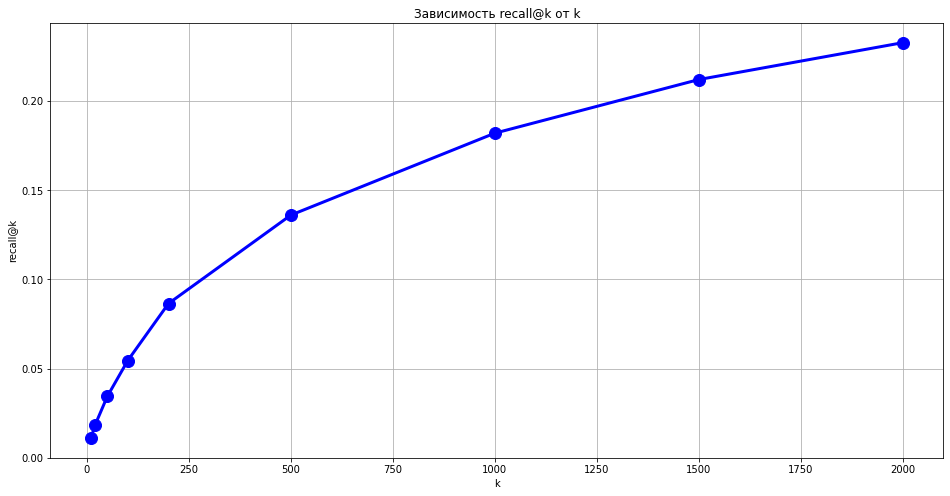

CPU times: user 6min 23s, sys: 4min 35s, total: 10min 59s
Wall time: 5min 39s


In [31]:
%%time
k = [10, 20, 50, 100, 200, 500, 1000, 1500, 2000]
recall_at_k_lst = []

for i in k:
    result_lvl_1[f'similar_items_recs_{i}'] = result_lvl_1['user_id'].apply(lambda x: \
                                                                          recommender.get_similar_items_recommendation(x, N=i))
    rec_at_k = result_lvl_1.apply(lambda row: recall_at_k(row[f'similar_items_recs_{i}'], row['actual'], k=i), axis=1).mean()
    recall_at_k_lst.append(rec_at_k)

plt.rcParams["figure.figsize"] = (16,8)
plt.plot(k, recall_at_k_lst, color='blue', marker='o', linewidth=3, markersize=12)
plt.title('Зависимость recall@k от k')
plt.xlabel('k')
plt.ylabel('recall@k')
plt.grid(True)
plt.show()

Увеличение k приводит к увеличению метрики recall_at_k.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [36]:
result_lvl_1.head(2)

,user_id,actual,similar_item_recommendations,similar_item_recall,als_recommendations,als_recall,own_recommendations,own_recall,similar_items_recs_10,similar_items_recs_20,similar_items_recs_50,similar_items_recs_100,similar_items_recs_200,similar_items_recs_500,similar_items_recs_1000,similar_items_recs_1500,similar_items_recs_2000,als_precision
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[990335, 5582712, 9297615, 5577022, 9803545, 9...",0.055046,"[1037332, 1077133, 841584, 959455, 856942, 904...",0.082569,"[856942, 9297615, 5577022, 877391, 9655212, 88...",0.110092,"[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...","[990335, 5582712, 9297615, 5577022, 9803545, 9...",0.18
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090537, 5569845, 1044078, 985999, 880888, 81...",0.040541,"[5569230, 916122, 1029743, 5569845, 875392, 91...",0.067568,"[911974, 1076580, 1103898, 5567582, 1056620, 9...",0.013514,"[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...","[8090537, 5569845, 1044078, 985999, 880888, 81...",0.10


In [37]:

data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [38]:
result_lvl_1['als_precision'] = result_lvl_1.apply(lambda row: precision_at_k(row['als_recommendations'], \
                                                                            row['actual'], k=200), axis=1)
als_recommendations = result_lvl_1[['user_id', 'als_recommendations']]
als_recommendations.head()

,user_id,als_recommendations
0,1,"[1037332, 1077133, 841584, 959455, 856942, 904..."
1,2,"[5569230, 916122, 1029743, 5569845, 875392, 91..."
2,4,"[821741, 1091383, 891423, 982790, 944588, 1082..."
3,6,"[1042616, 863632, 965267, 878996, 896613, 1026..."
4,7,"[10285022, 839419, 7168759, 12810393, 1117556,..."


In [39]:
valid_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index().rename(columns={'item_id': 'actual'})
valid_lvl_2 = valid_lvl_2.merge(als_recommendations, on='user_id', how='left')
valid_lvl_2.head(2)

,user_id,actual,als_recommendations
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1037332, 1077133, 841584, 959455, 856942, 904..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN


Произведем расчет на валидационных данных precision_at_k рекомендаций, выдаваемых моделью второго уровня. 

In [40]:

valid_lvl_2[valid_lvl_2.als_recommendations.notna()].apply(lambda row: \
                                                precision_at_k(row['als_recommendations'], row['actual'], k=5), axis=1).mean()

0.10067885117493428

Введем фиктивную переменную flag в список пользователей на втором уровне модели.

In [42]:
users_lvl_2 = pd.DataFrame(result_lvl_1['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['recommendations'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

s = users_lvl_2.apply(lambda x: pd.Series(x['recommendations']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('recommendations', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(2)

,user_id,item_id,flag
0,1,1037332,1
0,1,1077133,1


In [43]:
data_train_lvl_2 = data_val_lvl_1.copy()

In [44]:
data_train_lvl_2.columns

Index(['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'sales_value',
       'store_id', 'retail_disc', 'trans_time', 'week_no', 'coupon_disc',
       'coupon_match_disc'],
      dtype='object')

In [45]:
data_train_lvl_2.to_csv('data_train_lvl_2.csv')

Произведем объединение пользователей и таргетов.

In [47]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)
targets_lvl_2.head()

,user_id,item_id,target
0,1,1037332,0.0
1,1,1077133,0.0
2,1,841584,0.0
3,1,959455,0.0
4,1,856942,1.0


In [48]:
targets_lvl_2['target'].mean()

0.0838472913510784

Добавим цены.

In [49]:
price = data.groupby('item_id')['sales_value'].max()
item_features = item_features.merge(price, on='item_id', how='left').rename(columns={'sales_value': 'price'})

Добавим средние цены.

In [50]:
avg_price_by_cat = item_features.groupby('commodity_desc')['price'].mean()
item_features = item_features.merge(avg_price_by_cat, on='commodity_desc', how='left')\
                                                                .rename(columns={'price_x': 'price', 'price_y': 'avg_price'})

Добавим среднюю цену покупок в неделю.

In [55]:
x = data.groupby(['user_id', 'week_no']).basket_id.count().reset_index().groupby('user_id').agg(['count', 'sum'])
x.columns = x.columns.droplevel(0)
avg_purchases_per_week = x.iloc[:, 2:].apply(lambda row: row['sum'] / row['count'], axis=1)
avg_purchases_per_week.name = 'avg_purchases_per_week'
user_features = user_features.merge(avg_purchases_per_week, on='user_id', how='left')

In [56]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,basket_price,avg_purchases_per_week_x,avg_purchases_per_week_y
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,77.419817,24.828125,24.828125
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,86.418470,24.363636,24.363636
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,82.333861,26.409091,26.409091
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,91.693154,26.750000,26.750000
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,21.855595,9.160714,9.160714


Объединим в таргеты для модели 2-го уровня фичи айтемов и фичи пользователей.

In [58]:

item_features_tmp = item_features[['item_id',
                                    'manufacturer',
                                    'department',
                                    'brand',
                                    'commodity_desc',
                                    'price',
                                    'avg_price']]

user_features_tmp = user_features[['user_id',
                                    'age_desc',
                                    'income_desc',
                                    'household_size_desc',
                                    'basket_price']]

targets_lvl_2 = targets_lvl_2.merge(item_features_tmp, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features_tmp, on='user_id', how='left')

targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,price,avg_price,age_desc,income_desc,household_size_desc,basket_price
0,1,1037332,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,9.56,3.227402,65+,35-49K,2,77.419817
1,1,1077133,0.0,35,DRUG GM,National,MAGAZINE,2.99,4.810246,65+,35-49K,2,77.419817
2,1,841584,0.0,1046,GROCERY,National,COFFEE,8.38,6.924252,65+,35-49K,2,77.419817
3,1,959455,0.0,159,GROCERY,National,BAKED BREAD/BUNS/ROLLS,5.98,3.263789,65+,35-49K,2,77.419817
4,1,856942,1.0,159,GROCERY,National,BAKED BREAD/BUNS/ROLLS,15.00,3.263789,65+,35-49K,2,77.419817


In [59]:

targets_lvl_2['target'].mean()

0.0838472913510784

Разделим targets_lvl_2 на тренировочные наборы с разбиением по признакам и целевой переменной.

In [60]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2['target']

In [61]:
X_train.columns

Index(['user_id', 'item_id', 'manufacturer', 'department', 'brand',
       'commodity_desc', 'price', 'avg_price', 'age_desc', 'income_desc',
       'household_size_desc', 'basket_price'],
      dtype='object')

In [62]:
cat_columns = ['manufacturer',
               'department',
               'brand',
               'commodity_desc',
               'age_desc',
               'income_desc',
               'household_size_desc']

X_train[cat_columns] = X_train[cat_columns].astype('category')

Создадим модель и обучим ее.

In [78]:
model_lgb = LGBMClassifier(objective='binary', 
                           max_depth=3, 
                           n_estimators=300, 
                           learning_rate=0.01, 
                           n_jobs=4, num_leaves=32,
                           categorical_feature=cat_columns)

model_lgb.fit(X_train, y_train.values)

train_preds = model_lgb.predict_proba(X_train)[:, 1]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Построим диаграмму важности признаков.

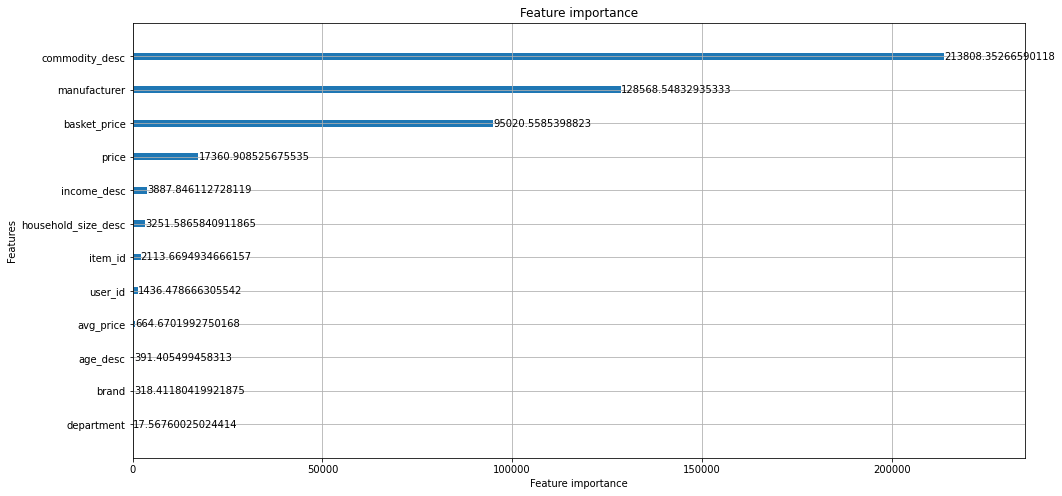

In [82]:
plot_importance(model_lgb, figsize=(16, 8), importance_type='gain')

In [80]:
targets_lvl_2['preds'] = train_preds
targets_lvl_2.sort_values(['user_id', 'preds'], ascending=[True, False], inplace=True)
lgb_recommendations = targets_lvl_2.groupby('user_id').head(5).groupby('user_id')['item_id'].unique().reset_index()
lgb_recommendations.head()

,user_id,item_id
0,1,"[1064002, 828588, 5577022, 894439, 9677620]"
1,2,"[1021324, 854852, 1017369, 875392, 9858920]"
2,4,"[944588, 1131438, 1052294, 901916, 935393]"
3,6,"[996070, 933637, 866211, 1051516, 6548453]"
4,7,"[959179, 854405, 839419, 849578, 913144]"


Произведем расчет precision_at_k полученной модели.

In [81]:
valid_lvl_2 = valid_lvl_2.merge(lgb_recommendations, on='user_id', how='left')
valid_lvl_2.rename(columns={'item_id': 'lgb_recommendations'}, inplace=True)
valid_lvl_2[valid_lvl_2.als_recommendations.notna()].apply(lambda row: precision_at_k(row['lgb_recommendations'], \
                                                                                      row['actual'], k=5), axis=1).mean()

ValueError: ignored